# LOCAL SEARCH - ANÁLISE DE RESULTADOS

 - ITA | PG-CTE-S | TE-282 - Meta-heurísticas
 - Professor Dr. Angelo Passaro
 - Aluno: Rafael Caneiro de Oliveira
 - Versao: 0.1
 - Data: 26/10/2021

## Bibliotecas | Parâmetros | Funções

In [13]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
from ast import literal_eval
from tqdm.auto import tqdm
import ray
import os

PATH = Path.cwd().parent
RAW_PATH = Path(PATH, "./data/raw/") 
LOG_PATH = Path(PATH, "./data/log/")
print(LOG_PATH)


/home/rco/github/s_metaheuristic/data/log


In [14]:
def read_port_files(n_port):
    filepath = Path(RAW_PATH, 'port' + str(n_port) + '.txt')
    with open(filepath) as fp:
        # quantidade de ativos no portfolio
        n_assets = int(fp.readline())
        # armazena as estatisticas do ativo
        r_mean = []
        r_std = []
        for n in range(n_assets):
            line = fp.readline()
            r_mean.append(float(line.strip().split()[0]))
            r_std.append(float(line.strip().split()[1]))

        # obtem o restante da matriz de covariancia
        cnt = 32
        i = []
        j = []
        cov = []
        line = fp.readline()
        while line:
            i.append(int(line.strip().split(' ')[0]))
            j.append(int(line.strip().split(' ')[1]))
            cov.append(float(line.strip().split(' ')[2]))
            line = fp.readline()
    fp.close()
    # retorna dataframe com estatisticas dos ativos do portfolio
    df_stats = pd.DataFrame({'port':n_port,
                             'i':[i_+1 for i_ in range(n_assets)],
                             'r_mean':r_mean,
                             'r_std':r_std})
    print(df_stats.shape)

    # retorna dataframe com matriz de covariancia dos ativos do portfolio
    df_cov_mx = pd.DataFrame({'port':n_port,
                             'i':i,
                             'j':j,
                             'cov':cov})
    print(df_cov_mx.shape)
    return df_stats, df_cov_mx

## Carrega Dados

In [15]:
df_stats_list = []
df_cov_mx_list =[]
for p in range(1,6,1):
    df_stats, df_cov_mx = read_port_files(p)
    df_stats_list.append(df_stats)
    df_cov_mx_list.append(df_cov_mx)
    
df_stats = pd.concat(df_stats_list)
df_cov_mx = pd.concat(df_cov_mx_list)

(31, 4)
(496, 4)
(85, 4)
(3655, 4)
(89, 4)
(4005, 4)
(98, 4)
(4851, 4)
(225, 4)
(25425, 4)


In [16]:
portfolios = {
    1:'Hang Seng - Hong Kong',
    2:'DAX - German Blue Chips',
    3:'FTSE - London',
    4:"S&P - Standard and Poor's 500 - US",
    5:'Nikkei - Tokyo'
}
df_stats['portfolio'] = df_stats.port.map(portfolios)
df_cov_mx['portfolio'] = df_cov_mx.port.map(portfolios)

In [17]:
uefs = []
for port in range(5):
    uef = pd.read_csv(Path(RAW_PATH, 'portef' + str(port+1) + '.txt'), header=None, sep='\s+')
    uef.columns = ['mean_return', 'var_return']
    uef['port'] = port + 1
    uefs.append(uef)
uef = pd.concat(uefs, ignore_index=True).reset_index(drop=True)
uef['portfolio'] = uef.port.map(portfolios)
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


In [18]:
@ray.remote
def import_logs(filename):
    try:
        file_path = Path(LOG_PATH, filename)
        df = pd.read_csv(file_path, low_memory=False)
        df['filename'] = filename
        df.loc[df[-1:].index, 'last_iter'] = 1
    except:
        print(filename)

    return df

# ray.init(num_cpus=16)

futures = [import_logs.remote(filename) for filename in os.listdir(LOG_PATH) if filename != '.DS_Store']
dfs = ray.get(futures)


In [19]:

all_data = pd.concat(dfs, ignore_index=True)
all_data.reset_index(drop=True, inplace=True)
all_data.rename({'move_strategy':'move_str', 'selection_strategy':'selec_str'}, axis=1, inplace=True)
print(all_data.shape)
best_data = all_data[all_data.last_iter==1]
print(best_data.shape)

(5111991, 19)
(5113, 19)


In [20]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5111991 entries, 0 to 5111990
Data columns (total 19 columns):
 #   Column      Dtype  
---  ------      -----  
 0   iter        int64  
 1   obj         float64
 2   aug_obj     float64
 3   return      float64
 4   X           object 
 5   Z           object 
 6   Q           float64
 7   max_iter    int64  
 8   neighbours  int64  
 9   alpha       float64
 10  exp_return  float64
 11  n_port      int64  
 12  k           int64  
 13  move_str    object 
 14  seed        float64
 15  selec_str   object 
 16  tag         object 
 17  filename    object 
 18  last_iter   float64
dtypes: float64(8), int64(5), object(6)
memory usage: 741.0+ MB


## Portfólios

### Geral

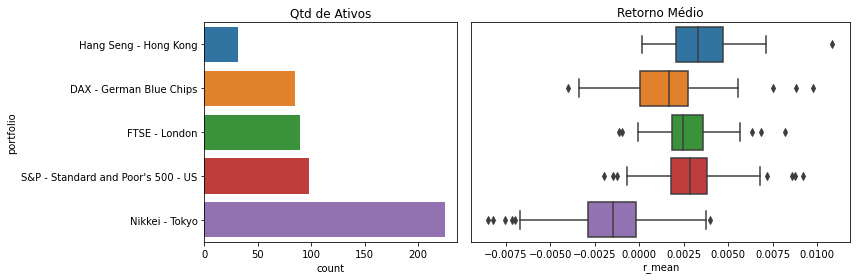

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'width_ratios': [1, 1.5]})
sns.countplot(data=df_stats, y='portfolio', ax=ax[0])
ax[0].title.set_text('Qtd de Ativos')
sns.boxplot(data=df_stats, y='portfolio', x='r_mean', ax=ax[1])
ax[1].title.set_text("Retorno Médio")
ax[1].get_yaxis().set_ticks([])
ax[1].set_ylabel('')
fig.tight_layout()

In [22]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


### Matriz de Covariância

In [23]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j].describe().T

,count,mean,std,min,25%,50%,75%,max
port,37904.0,4.336350,1.068738,1.000000,4.000000,5.000000,5.00000,5.000000
i,37904.0,60.152728,49.736086,1.000000,20.000000,46.000000,88.00000,224.000000
j,37904.0,120.305456,62.150969,2.000000,68.000000,113.000000,178.00000,225.000000
cov,37904.0,0.388782,0.166550,-0.145815,0.258983,0.419793,0.51717,0.909412


<AxesSubplot:>

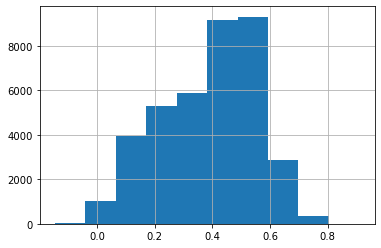

In [24]:
df_cov_mx[df_cov_mx.i!=df_cov_mx.j]['cov'].hist()

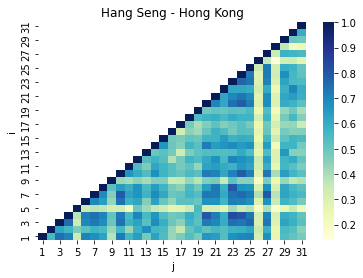

In [25]:
portfolio = 1
df_cov_pivot = df_cov_mx[df_cov_mx.port==portfolio].pivot(index='i', columns='j', values='cov')
sns.heatmap(df_cov_pivot.iloc[::-1], cmap="YlGnBu") 
plt.title(portfolios[portfolio])
ax=ax

### Fronteiras de Eficiência Irrestrira - UEF

In [26]:
uef.head()

,mean_return,var_return,port,portfolio
0,0.010865,0.004776,1,Hang Seng - Hong Kong
1,0.010861,0.004768,1,Hang Seng - Hong Kong
2,0.010857,0.004760,1,Hang Seng - Hong Kong
3,0.010853,0.004752,1,Hang Seng - Hong Kong
4,0.010849,0.004745,1,Hang Seng - Hong Kong


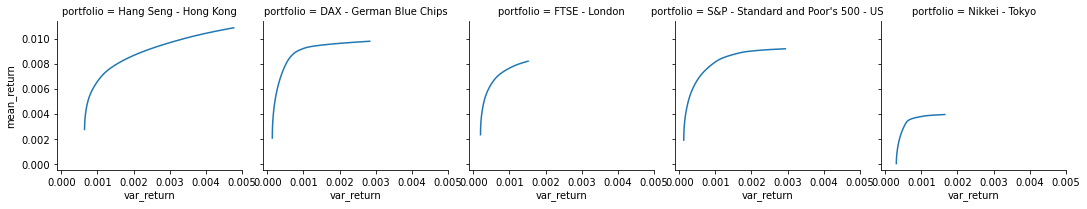

In [27]:
g = sns.relplot(data=uef, y='mean_return', x='var_return', col='portfolio', kind='line', height=3)
ax=ax

## Curvas de Aprendizado

In [28]:
all_data = all_data[all_data.n_port==1]

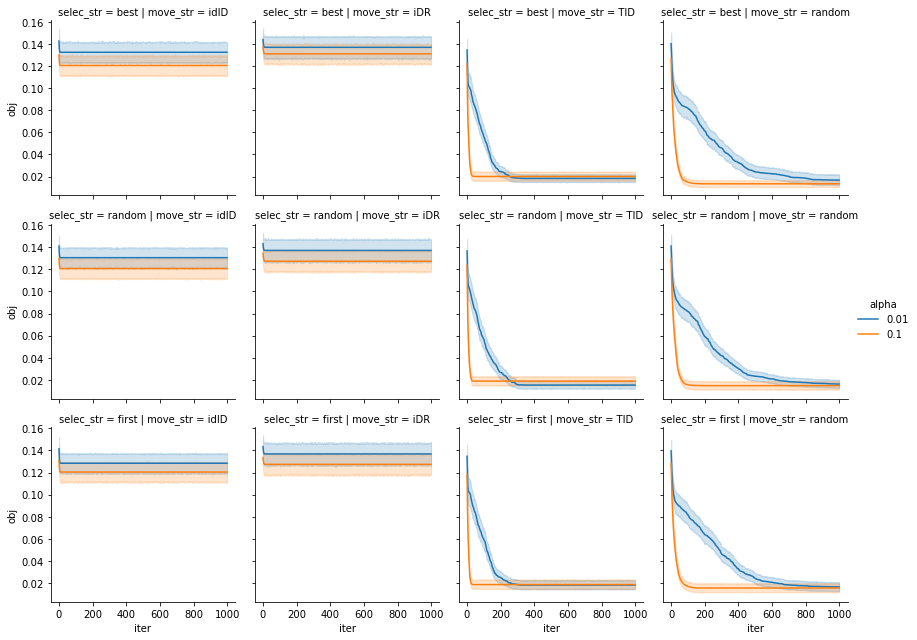

In [29]:
g = sns.FacetGrid(
    data=all_data, col='move_str', row='selec_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'obj')
g.add_legend()
g=g

In [30]:
g = sns.FacetGrid(
    data=all_data, col='move_str', row='selec_str', hue='alpha')
g.map(sns.lineplot, 'iter', 'Q')
g.add_legend()
g=g

## Análise Best - Portfólio 1

In [37]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [38]:
print(best_data.shape)
best_data.drop(['X', 'Z',],axis=1,).head()

(137, 20)


,iter,obj,aug_obj,return,Q,max_iter,neighbours,alpha,exp_return,n_port,k,move_str,seed,selec_str,tag,filename,last_iter,min_obj
999,999,0.021517,0.023666,0.002775,9.0,1000,100,0.1,0.0020,1,10,idID,0,random,single_objective,log_gls_20211119_001004_894324.csv,1.0,0.007440
1999,999,0.020004,0.020041,0.002775,10.0,1000,100,0.1,0.0025,1,10,iDR,0,random,single_objective,log_gls_20211119_001015_054895.csv,1.0,0.016674
2999,999,0.020004,0.020041,0.002775,10.0,1000,100,0.1,0.0025,1,10,iDR,0,first,single_objective,log_gls_20211119_001128_591072.csv,1.0,0.016674
3999,999,0.017014,0.017138,0.003936,9.0,1000,100,0.1,0.0035,1,10,TID,0,random,single_objective,log_gls_20211119_001051_593570.csv,1.0,0.017014
4999,999,0.016585,0.016779,0.002775,9.0,1000,100,0.1,0.0020,1,10,TID,0,random,single_objective,log_gls_20211119_001124_117854.csv,1.0,0.007440


In [39]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,137.0,999.000000,0.000000e+00,999.000000,999.000000,999.000000,999.000000,999.000000
obj,137.0,0.021502,8.096834e-03,0.007440,0.017217,0.020004,0.021615,0.055865
aug_obj,137.0,0.022153,8.446988e-03,0.007572,0.017354,0.020041,0.023666,0.055973
return,137.0,0.003356,5.348957e-04,0.002775,0.002775,0.003638,0.003936,0.004137
Q,137.0,9.262774,4.417557e-01,9.000000,9.000000,9.000000,10.000000,10.000000
max_iter,137.0,1000.000000,0.000000e+00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
neighbours,137.0,100.000000,0.000000e+00,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,137.0,0.100000,2.507169e-16,0.100000,0.100000,0.100000,0.100000,0.100000
exp_return,137.0,0.002153,1.102407e-03,0.000500,0.001500,0.002000,0.003000,0.004000
n_port,137.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


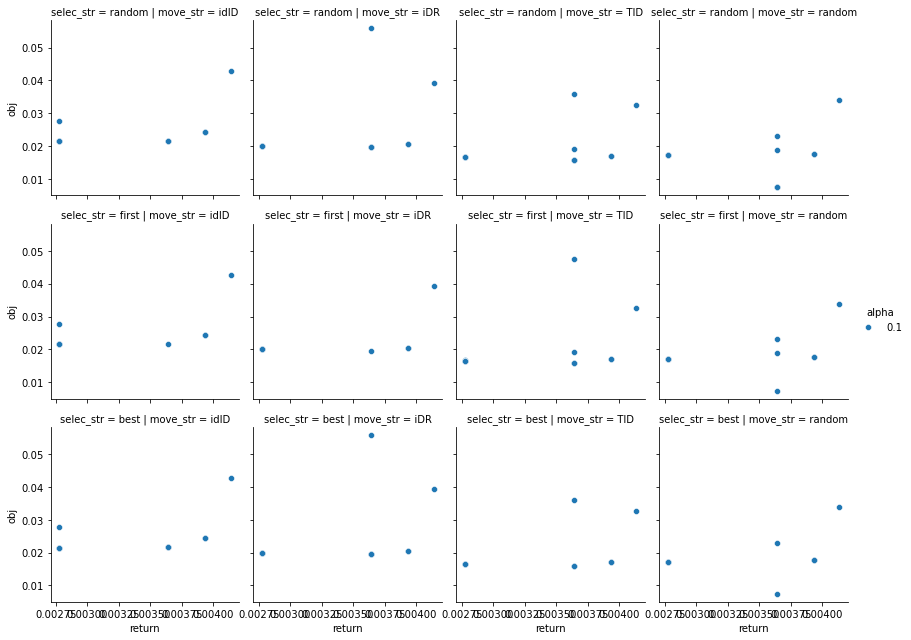

In [40]:
g = sns.FacetGrid(data=best_data, col='move_str', row='selec_str', hue='alpha')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

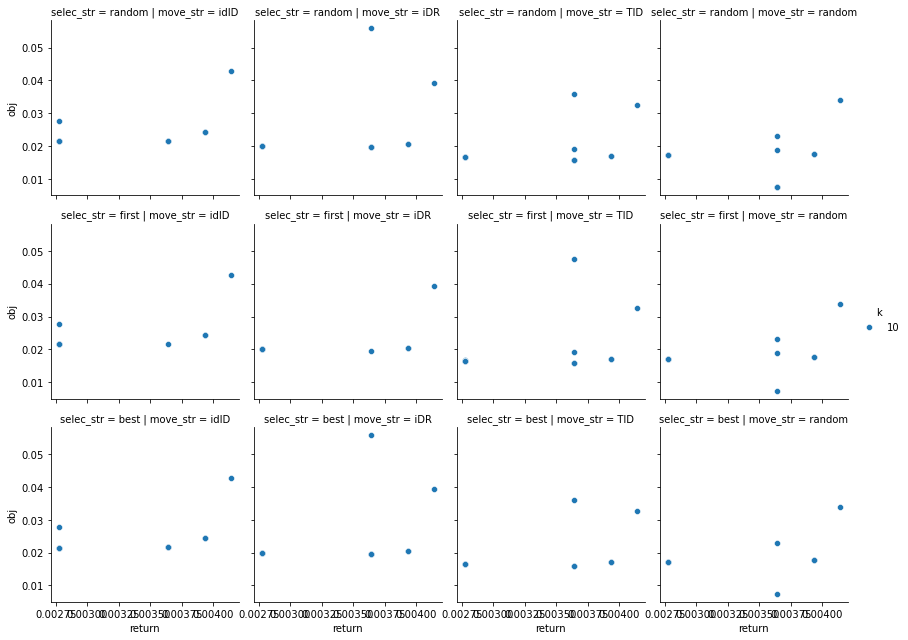

In [41]:
g = sns.FacetGrid(data=best_data, col='move_str', row='selec_str', hue='k')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

In [42]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,137.0,999.000000,0.000000e+00,999.000000,999.000000,999.000000,999.000000,999.000000
obj,137.0,0.021502,8.096834e-03,0.007440,0.017217,0.020004,0.021615,0.055865
aug_obj,137.0,0.022153,8.446988e-03,0.007572,0.017354,0.020041,0.023666,0.055973
return,137.0,0.003356,5.348957e-04,0.002775,0.002775,0.003638,0.003936,0.004137
Q,137.0,9.262774,4.417557e-01,9.000000,9.000000,9.000000,10.000000,10.000000
max_iter,137.0,1000.000000,0.000000e+00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
neighbours,137.0,100.000000,0.000000e+00,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,137.0,0.100000,2.507169e-16,0.100000,0.100000,0.100000,0.100000,0.100000
exp_return,137.0,0.002153,1.102407e-03,0.000500,0.001500,0.002000,0.003000,0.004000
n_port,137.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
df_stats[df_stats.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
port,31.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
i,31.0,16.000000,9.092121,1.000000,8.500000,16.000000,23.500000,31.000000
r_mean,31.0,0.003504,0.002186,0.000141,0.002043,0.003286,0.004725,0.010865
r_std,31.0,0.045723,0.007296,0.035848,0.040043,0.045450,0.050112,0.069105


In [44]:
uef[uef.port==1].describe().T

,count,mean,std,min,25%,50%,75%,max
mean_return,2000.0,0.006825,0.002334,0.002784,0.004804,0.006825,0.008845,0.010865
var_return,2000.0,0.001579,0.001116,0.000642,0.000716,0.001058,0.002150,0.004776
port,2000.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0, 0.5, 'mean_return')

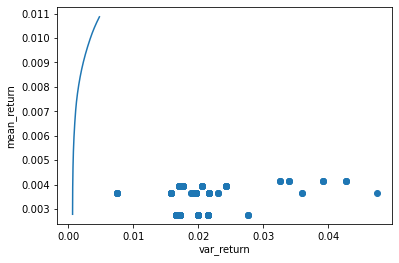

In [45]:
data = best_data[best_data['obj']<0.01]
data = data[data.n_port==1]
plt.plot(uef[uef.port==1].var_return, uef[uef.port==1].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [46]:
best_data.describe().T

,count,mean,std,min,25%,50%,75%,max
iter,137.0,999.000000,0.000000e+00,999.000000,999.000000,999.000000,999.000000,999.000000
obj,137.0,0.021502,8.096834e-03,0.007440,0.017217,0.020004,0.021615,0.055865
aug_obj,137.0,0.022153,8.446988e-03,0.007572,0.017354,0.020041,0.023666,0.055973
return,137.0,0.003356,5.348957e-04,0.002775,0.002775,0.003638,0.003936,0.004137
Q,137.0,9.262774,4.417557e-01,9.000000,9.000000,9.000000,10.000000,10.000000
max_iter,137.0,1000.000000,0.000000e+00,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
neighbours,137.0,100.000000,0.000000e+00,100.000000,100.000000,100.000000,100.000000,100.000000
alpha,137.0,0.100000,2.507169e-16,0.100000,0.100000,0.100000,0.100000,0.100000
exp_return,137.0,0.002153,1.102407e-03,0.000500,0.001500,0.002000,0.003000,0.004000
n_port,137.0,1.000000,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
best_data['min_obj'] = best_data.groupby(['exp_return', 'k'], as_index=False)['obj'].transform(min)
best_best_data = best_data[best_data.obj==best_data.min_obj]
print(best_best_data.shape)

(20, 20)


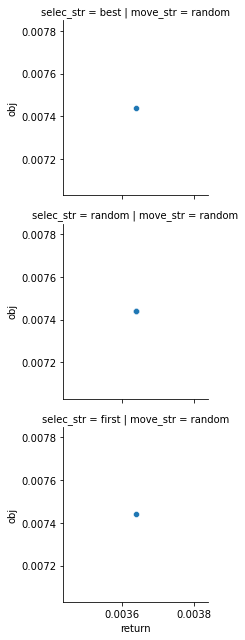

In [48]:
g = sns.FacetGrid(data=best_best_data[best_best_data.obj<0.01], col='move_str', row='selec_str')
g.map(sns.scatterplot, 'return', 'obj')
g.add_legend()
g=g

Text(0, 0.5, 'mean_return')

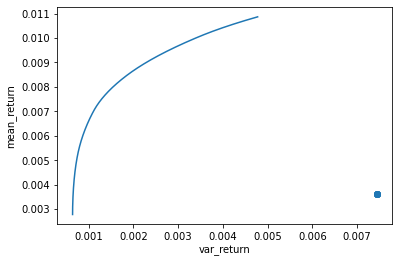

In [49]:
port = 1
data = best_best_data[best_best_data.n_port==port]
data = data[data['obj']<0.01]
plt.plot(uef[uef.port==port].var_return, uef[uef.port==port].mean_return)
plt.scatter(data.obj, data['return'])
plt.xlabel("var_return")
plt.ylabel("mean_return")

In [50]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return          0.0005  0.0010  0.0015  0.0020  0.0025  0.0030  0.0035  \
move_str selec_str                                                           
TID      best            2       1       2       1       1       2       1   
         first           1       1       2       2       2       1       2   
         random          2       1       2       2       2       2       1   
iDR      best            2       2       2       2       1       2       1   
         first           1       1       2       1       1       1       1   
         random          2       2       2       1       2       2       1   
idID     best            2       1       2       1       2       1       2   
         first           1       2       1       1       1       1       1   
         random          1       1       1       2       1       2       2   
random   best            1       1       2       1       2       1       1   
         first           2       1       1       1       2       2       1   
         random          2       1       2       2       2       2       1   

exp_return          0.0040  
move_str selec_str          
TID      best            1  
         first           1  
         random          1  
iDR      best            1  
         first           1  
         random          1  
idID     best            1  
         first           1  
         random          1  
random   best            1  
         first           1  
         random          1

In [51]:
best_data.groupby(['Q', 'move_str', 'selec_str'], as_index=False)['obj']\
    .count()\
    .pivot(index=['move_str', 'selec_str'], columns='Q', values='obj')

Q                   9.0   10.0
move_str selec_str            
TID      best       11.0   NaN
         first      11.0   1.0
         random     13.0   NaN
iDR      best        NaN  13.0
         first       NaN   9.0
         random      NaN  13.0
idID     best       12.0   NaN
         first       9.0   NaN
         random     11.0   NaN
random   best       10.0   NaN
         first      11.0   NaN
         random     13.0   NaN

In [52]:
best_data.groupby(['exp_return', 'move_str', 'selec_str'], as_index=False)['obj']\
    .min()\
    .pivot(index=['move_str', 'selec_str'], columns='exp_return', values='obj')

exp_return            0.0005    0.0010    0.0015    0.0020    0.0025  \
move_str selec_str                                                     
TID      best       0.015841  0.016585  0.015841  0.016585  0.016674   
         first      0.016585  0.016585  0.015841  0.015841  0.016674   
         random     0.015841  0.016585  0.015841  0.015841  0.016674   
iDR      best       0.019623  0.019623  0.019623  0.019623  0.020004   
         first      0.020004  0.020004  0.019623  0.020004  0.020004   
         random     0.019623  0.019623  0.019623  0.020004  0.019623   
idID     best       0.021517  0.021517  0.021517  0.021517  0.021615   
         first      0.021517  0.021517  0.021517  0.021517  0.027704   
         random     0.021517  0.021517  0.021517  0.021517  0.027704   
random   best       0.017217  0.017217  0.007440  0.017217  0.017217   
         first      0.007440  0.017217  0.017217  0.017217  0.017217   
         random     0.007440  0.017217  0.007440  0.007440  0.017217   

exp_return            0.0030    0.0035    0.0040  
move_str selec_str                                
TID      best       0.017014  0.017014  0.032650  
         first      0.017014  0.017014  0.032650  
         random     0.017014  0.017014  0.032650  
iDR      best       0.020524  0.020524  0.039248  
         first      0.020524  0.020524  0.039248  
         random     0.020524  0.020524  0.039248  
idID     best       0.024298  0.021615  0.042735  
         first      0.024298  0.024298  0.042735  
         random     0.021615  0.021615  0.042735  
random   best       0.017685  0.017685  0.033953  
         first      0.017685  0.017685  0.033953  
         random     0.017685  0.017685  0.033953

In [53]:
best_best_data = best_data.groupby(['exp_return'], as_index=False)['obj'].min()
print(best_best_data.shape)
best_best_data.head()

(8, 2)


,exp_return,obj
0,0.0005,0.007440
1,0.0010,0.016585
2,0.0015,0.007440
3,0.0020,0.007440
4,0.0025,0.016674


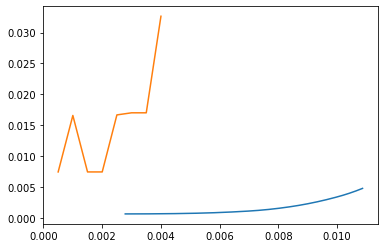

In [54]:
plt.plot(uef[uef.port==1].mean_return, uef[uef.port==1].var_return)
plt.plot(best_best_data.exp_return, best_best_data.obj)